In [1]:
%pylab inline
import seaborn as sns

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Extrapolation of COSMOS sersic fits to fainter magnitudes

## Modelling strategy

We want to model the following joint distribution of sersic profile parameters for a given magnitude:

$$ p \left( I,  R, n,  q  \mid mag_{auto} \right)$$

where $I$ is the intensity at the half-light radius, $R$ is the half-light radius measured along the major axis, $n$ is the sersic index, $q$ is the ratio of minor axis to major axis.

As a simplifying assumption, we assume that $n$ and $q$ are independent of magnitude, size and intensity:

$$p \left( n,  q  \mid mag_{auto}, I, R \right) = p(n,  q)$$

To remove one more degree of freedom, we also use the following relation that links the parameters of the sersic model to the magnitude:

$$ F = 2 \pi  I  R^2  n  \Gamma(2n)  e^{\kappa}  \kappa^{- 2 n}  q$$

$$ mag_{sersic} = -2.5 \log(F) + m_0$$

where $\kappa = n \ e^{0.6950 - \frac{0.1789}{n}}$. For a given magnitude, if 3 parameters are given, we can deduce the 4th one with this formula.

So, we can decompose the joint distribution estimation problem as:

$$ p \left( I,  R, n,  q  \mid mag_{auto} \right) = p(R \mid mag_{auto}, I, n, q) \  p(n, q) \ p (I \mid mag_{auto})$$

Using the previous expression for the magnitude, the first term is (almost) deterministic, to estimate the joint distribution of $n$ and $q$ in the second term we use a Kernel Density Estimate, and finally we model the last term in log scale using a Logistic distribution with mean and scale parameters affine functions of the magnitude.
Note that we model $I$ as a function of magnitude instead of $R$ because we find the distribution of $\log (R)$to be skewed and difficult to model. We adopt the following model for $I$:

$$ \log(I) \sim \mbox{Logistic}( \mu(mag_{auto}), \ s(mag_{auto})) $$

where the mean and scale parameters are affine functions of the magnitude:

$$  \mu(mag_{auto}) = a_\mu + b_\mu mag_{auto} \qquad \mbox{and} \qquad s(mag_{auto}) = a_s + b_s mag_{auto} $$



## Fitting the model to COSMOS data

Assuming that *GalSim* and the cosmos training data are correctly installed (see [the GalSim documentation](https://github.com/GalSim-developers/GalSim/wiki/RealGalaxy-Data)), the following command initialize and fit the model in a specified magnitude range.

In [2]:
from cosmos_extrapolation import sersic_model

# Initializes the model and loads the data
model = sersic_model()

# Perform the fit to the sersic fits in the specified magnitude range
model.fit(mag_range=[22., 23.5])

Fit of intensities successfull:  True
Fit of sersic magnitudes successfull:  True


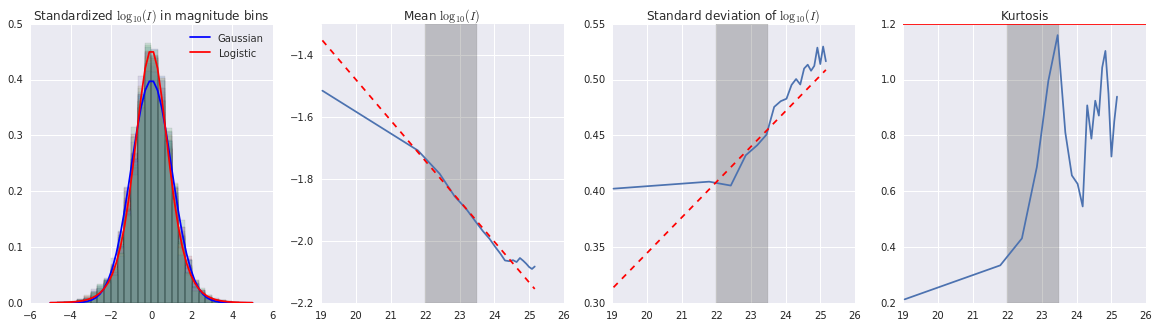

In [4]:
# Outputs a few plots comparing fits to input distributions
model.plot_fit_I(nbins=20) # nbins is the number of magnitude bins to use to compute the mean and standard deviation

These plots illustrate the fit to the log intensity as a function of magnitude. 

The first one shows a superposition of the standardized histograms (shifted to 0 mean and scaled to unit variance) in each magnitude bin. This dsitribution is slightly more peaked than a Gaussian and a Logistic distribution is a much better fit.

The central plots show the measured mean and standard deviation as a fuction of magnitude (solid blue). The gray region shows the magnitude range used for the fit. The dashed red line is the affine fit of the mean and scale of the Logistic distribution.

The last plot just shows the measured excess kurtosis of the log intensity distribution, and the red line shows the excess kurtosis of a Logistic distribution.

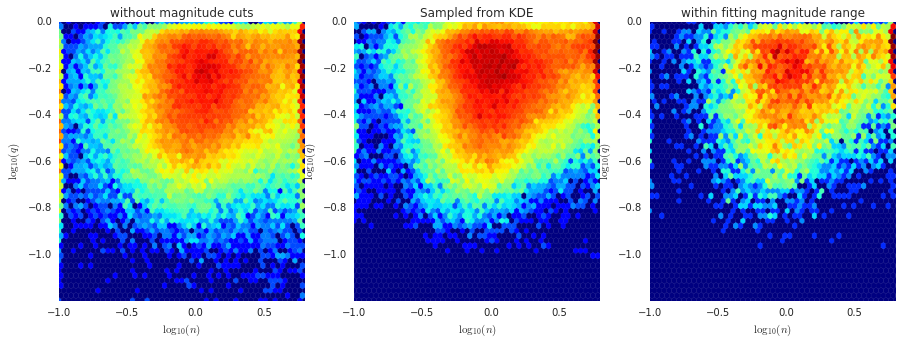

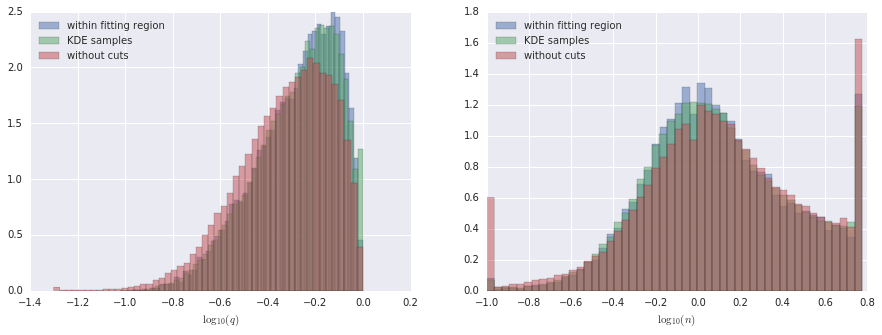

In [8]:
# Ouputs plots to evaluate the KDE fit of the joint distribution of sersic index and axis ratio
model.plot_fit_kde()

In the top plot, the left panel shows the joint density of sersic index and axis ratio for the whole COSMOS dataset (down to mag=25.2). The right panel shows the joint density only for the galaxies within the fitting region. The central panel shows the distribution sampled from the KDE. It is learned from the right panel but still looks fairly representative compared to the left panel.

The bottom plots compare the marginal distributions in the same 3 situations.

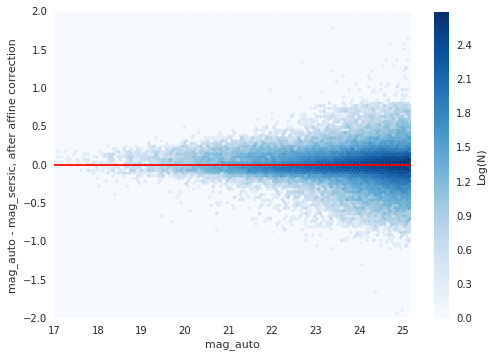

In [10]:
# Plots the residuals between magnitudes computed from the sersic fit and mag_auto
model.plot_fit_mag()

This plot shows the residuals between the magnitudes computed from the sersic parameters and the mag_auto values.
We fit an affine model between these two magnitudes to remove any potential bias and slopes. 


## Sampling from the model

Now that the model is fitted, we can sample from it and extrapolate outside of the fitting region.

In [85]:
# Retrieve the real cosmos catalog entries 
mag = model.cat['mag_auto'][model.mask]
I = model.cat['sersicfit'][model.mask,0]
R = model.cat['sersicfit'][model.mask,1]
n = model.cat['sersicfit'][model.mask,2]
q = model.cat['sersicfit'][model.mask,3]

# Sample new sersic parameters for a given array of magnitudes
mI, mR, mn, mq = model.sample(mag)

In [87]:
# Build some color maps for later
color = sns.color_palette()[0] ; color_rgb = mpl.colors.colorConverter.to_rgb(color) ; colors = [sns.set_hls_values(color_rgb, l=l) for l in np.linspace(1, 0, 12)]
cmap1 = sns.blend_palette(colors, as_cmap=True)
color = sns.color_palette()[2] ; color_rgb = mpl.colors.colorConverter.to_rgb(color) ; colors = [sns.set_hls_values(color_rgb, l=l) for l in np.linspace(1, 0, 12)]
cmap2 = sns.blend_palette(colors, as_cmap=True)

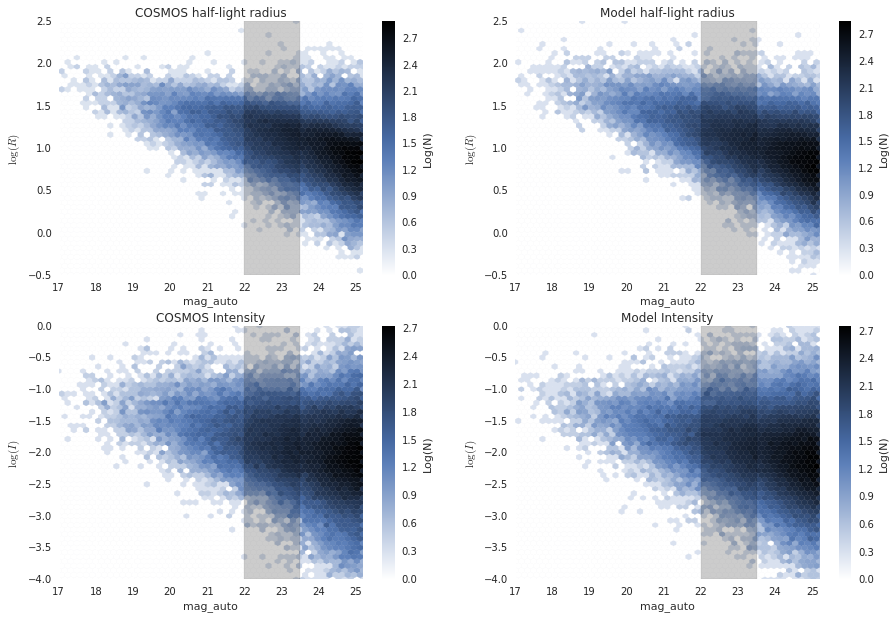

In [103]:
# Comparison of half-light radius  and intensity distributions
figure(figsize=(15,10))
subplot(221)
hexbin(mag,log10(R),bins='log',gridsize=50,cmap=cmap1, extent=(17,25.2,-0.5,2.5))
xlabel('mag_auto')
ylabel('$\log(R)$')
title('COSMOS half-light radius')
axvspan(model.mag_range[0],model.mag_range[1],alpha=0.2,color='k')
colorbar(label='Log(N)')

subplot(222)
hexbin(mag,log10(mR),bins='log',gridsize=50,cmap=cmap1, extent=(17,25.2,-0.5,2.5))
axvspan(model.mag_range[0],model.mag_range[1],alpha=0.2,color='k')
xlabel('mag_auto')
ylabel('$\log(R)$')
title('Model half-light radius')
colorbar(label='Log(N)')

subplot(223)
hexbin(mag,log10(I),bins='log',gridsize=50,cmap=cmap1, extent=(17, 25.2, -4, 0))
xlabel('mag_auto')
ylabel('$\log(I)$')
title('COSMOS Intensity')
axvspan(model.mag_range[0],model.mag_range[1],alpha=0.2,color='k')
colorbar(label='Log(N)')

subplot(224)
hexbin(mag,log10(mI),bins='log',gridsize=50,cmap=cmap1, extent=(17, 25.2, -4, 0))
axvspan(model.mag_range[0],model.mag_range[1],alpha=0.2,color='k')
xlabel('mag_auto')
ylabel('$\log(I)$')
title('Model Intensity')
colorbar(label='Log(N)');

These distribution plots compare the distributions of $R$ and $I$ in the original data (left) and sampled from the model (right). The shaded region highlights the range of magnitudes included in the fit.

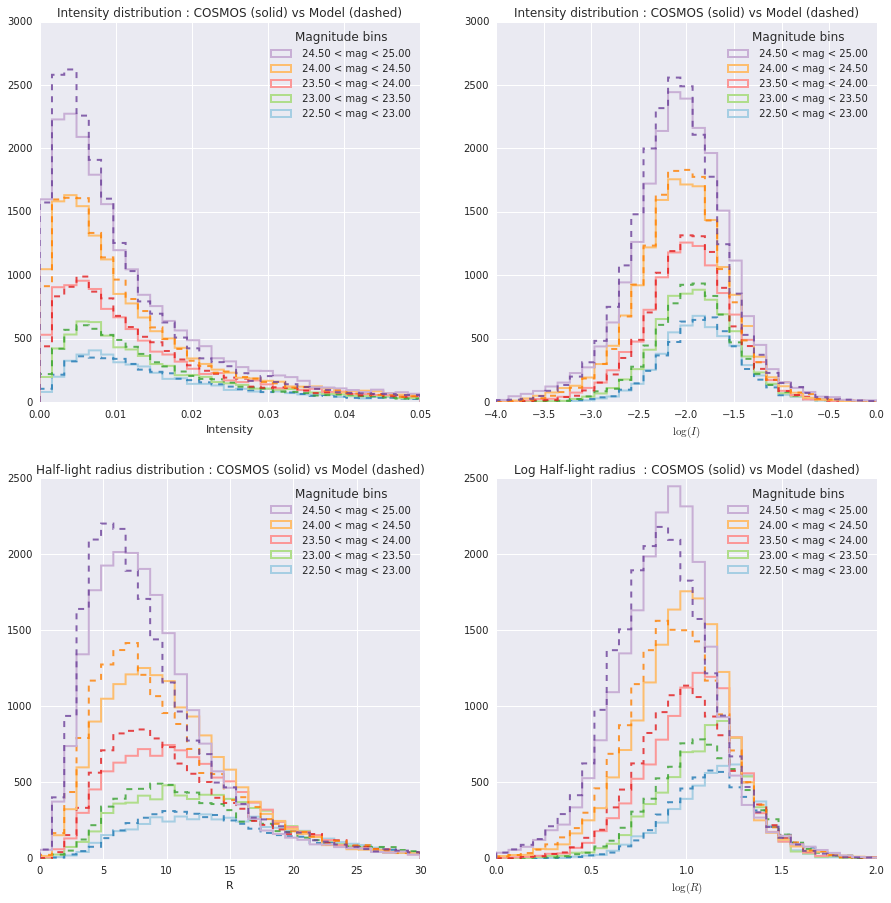

In [235]:
# Comparison of histograms in magnitude bins in a given range
mag_range = [22.5, 25] # Range of magnitudes
nbins = 5              # Number of bins (equal size bins)

sns.set_palette(sns.color_palette("Paired", 10))
figure(figsize=(15,15))
subplot(221)
for i in range(nbins):
    m_min = float(i)/ float(nbins) * (mag_range[1] - mag_range[0])  + mag_range[0]
    m_max = float(i+1)/ float(nbins) * (mag_range[1] - mag_range[0])  + mag_range[0]
    ind = (mag > m_min ) * (mag < m_max)
    
    sns.distplot(I[ind], hist_kws={"histtype": "step", "lw":2, "alpha": 1}, 
                 kde=False,bins=linspace(0,0.05,32), label=' %.2f < mag < %.2f'%(m_min,m_max ) )
    sns.distplot(mI[ind],hist_kws={"histtype": "step", "lw":2, "alpha": 0.8, "ls":'--'},
                 kde=False, bins=linspace(0,0.05,32))
    
xlim(0,0.05)
handles, labels = gca().get_legend_handles_labels()
legend(handles[::-1], labels[::-1], title='Magnitude bins')
title('Intensity distribution : COSMOS (solid) vs Model (dashed)')
xlabel('Intensity')

subplot(222)
for i in range(nbins):
    m_min = float(i)/ float(nbins) * (mag_range[1] - mag_range[0])  + mag_range[0]
    m_max = float(i+1)/ float(nbins) * (mag_range[1] - mag_range[0])  + mag_range[0]
    ind = (mag > m_min ) * (mag < m_max)
    
    sns.distplot(log10(I[ind]), hist_kws={"histtype": "step", "lw":2, "alpha": 1},kde=False, bins=linspace(-4,0.0,32), label=' %.2f < mag < %.2f'%(m_min,m_max ) )
    sns.distplot(log10(mI[ind]),hist_kws={"histtype": "step", "lw":2, "alpha": 0.8, "ls":'--'}, kde=False, bins=linspace(-4,0.0,32))
    
handles, labels = gca().get_legend_handles_labels()
legend(handles[::-1], labels[::-1], title='Magnitude bins')
title('Intensity distribution : COSMOS (solid) vs Model (dashed)')
xlabel('$\log(I)$');

subplot(223)
for i in range(nbins):
    m_min = float(i)/ float(nbins) * (mag_range[1] - mag_range[0])  + mag_range[0]
    m_max = float(i+1)/ float(nbins) * (mag_range[1] - mag_range[0])  + mag_range[0]
    ind = (mag > m_min ) * (mag < m_max)
    
    sns.distplot(R[ind], hist_kws={"histtype": "step", "lw":2, "alpha": 1}, kde=False, bins=linspace(0,30.0,32), label=' %.2f < mag < %.2f'%(m_min,m_max ) )
    sns.distplot(mR[ind],hist_kws={"histtype": "step", "lw":2, "alpha": 0.8, "ls":'--'}, kde=False, bins=linspace(0,30.0,32))
    
handles, labels = gca().get_legend_handles_labels()
legend(handles[::-1], labels[::-1], title='Magnitude bins')
title('Half-light radius distribution : COSMOS (solid) vs Model (dashed)')
xlabel('R')

subplot(224)
for i in range(nbins):
    m_min = float(i)/ float(nbins) * (mag_range[1] - mag_range[0])  + mag_range[0]
    m_max = float(i+1)/ float(nbins) * (mag_range[1] - mag_range[0])  + mag_range[0]
    ind = (mag > m_min ) * (mag < m_max)
    
    sns.distplot(log10(R[ind]), hist_kws={"histtype": "step", "lw":2, "alpha": 1}, bins=linspace(0.,2,32), kde=False,  label=' %.2f < mag < %.2f'%(m_min,m_max ) )
    sns.distplot(log10(mR[ind]),hist_kws={"histtype": "step", "lw":2, "alpha": 0.8, "ls":'--'}, bins=linspace(0,2.0,32), kde=False)
    
handles, labels = gca().get_legend_handles_labels()
legend(handles[::-1], labels[::-1], title='Magnitude bins')
title('Log Half-light radius  : COSMOS (solid) vs Model (dashed)')
xlabel('$\log(R)$');

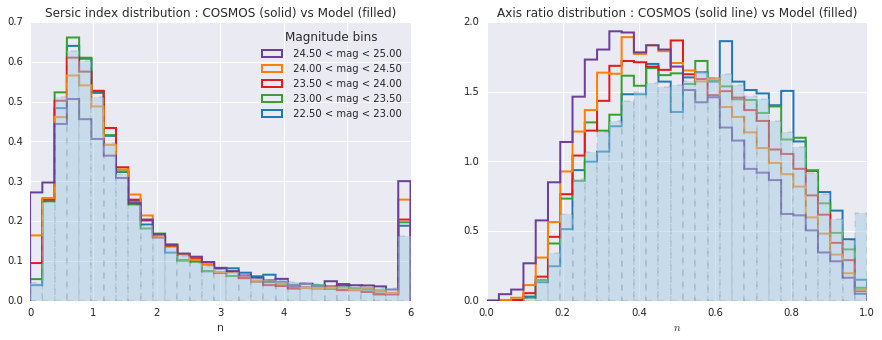

In [231]:
# Comparison of histograms in magnitude bins in a given range
mag_range = [22.5, 25] # Range of magnitudes
nbins = 5              # Number of bins (equal size bins)

sns.set_palette(sns.color_palette("Paired", 10))
figure(figsize=(15,5))
subplot(121)
for i in range(nbins):
    m_min = float(i)/ float(nbins) * (mag_range[1] - mag_range[0])  + mag_range[0]
    m_max = float(i+1)/ float(nbins) * (mag_range[1] - mag_range[0])  + mag_range[0]
    ind = (mag > m_min ) * (mag < m_max)
    sns.distplot(mn[ind],hist_kws={"histtype": "step", "lw":2, "alpha": 0., "ls":'--'}, norm_hist=True, bins=linspace(0.,6,32),kde=False)
    sns.distplot(n[ind], hist_kws={"histtype": "step", "lw":2, "alpha": 1}, norm_hist=True, kde=False,bins=linspace(0.,6,32), label=' %.2f < mag < %.2f'%(m_min,m_max ) )

sns.distplot(mn,hist_kws={"alpha": 0.5, "ls":'--'}, norm_hist=True, bins=linspace(0.,6,32), kde=False)
handles, labels = gca().get_legend_handles_labels()
legend(handles[::-1], labels[::-1], title='Magnitude bins')
title('Sersic index distribution : COSMOS (solid) vs Model (filled)')
xlabel('n')

subplot(122)
for i in range(nbins):
    m_min = float(i)/ float(nbins) * (mag_range[1] - mag_range[0])  + mag_range[0]
    m_max = float(i+1)/ float(nbins) * (mag_range[1] - mag_range[0])  + mag_range[0]
    ind = (mag > m_min ) * (mag < m_max)
    sns.distplot(mq[ind],hist_kws={"histtype": "step", "lw":2, "alpha": 0., "ls":'--'}, norm_hist=True, bins=linspace(0.,1,32), kde=False)
    sns.distplot(q[ind], hist_kws={"histtype": "step", "lw":2, "alpha": 1}, norm_hist=True, bins=linspace(0.,1,32), kde=False,  label=' %.2f < mag < %.2f'%(m_min,m_max ) )

sns.distplot(mq,hist_kws={"alpha": 0.5, "ls":'--'}, norm_hist=True, bins=linspace(0.,1,32), kde=False)
title('Axis ratio distribution : COSMOS (solid line) vs Model (filled)')
xlabel('$n$');